In [1]:
import pandas as pd
df = pd.read_csv("data/BindingDB_All.tsv", sep="\t",nrows=500)

In [2]:
cols = ['Target Name', 'Ligand SMILES', 'IC50 (nM)', 'Kd (nM)', 'Ki (nM)']
df_small = df[cols].dropna(subset=['Ligand SMILES'])

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# 假設這是你已經挑好的 DataFrame
# df_small = df[['Target Name', 'Ligand SMILES', 'IC50 (nM)', 'Kd (nM)', 'Ki (nM)']].dropna(subset=['Ligand SMILES'])

def calc_mol_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is None:
            raise ValueError("Invalid SMILES")
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        return pd.Series([mw, logp, tpsa, h_donors, h_acceptors])
    except:
        return pd.Series([None, None, None, None, None])

# 新欄位
df_small[['MolWt', 'LogP', 'TPSA', 'HDonors', 'HAcceptors']] = df_small['Ligand SMILES'].apply(calc_mol_features)


In [4]:
import numpy as np

# 把 IC50 轉成數字 (強制處理)
df_small['IC50 (nM)'] = pd.to_numeric(df_small['IC50 (nM)'], errors='coerce')

# 刪掉不能轉的
df_small = df_small[df_small['IC50 (nM)'].notna()]

# 計算 pIC50
df_small['pIC50'] = -np.log10(df_small['IC50 (nM)'] * 1e-9)



In [5]:
# 選擇要用的特徵
X = df_small[['MolWt', 'LogP', 'TPSA', 'HDonors', 'HAcceptors']]
y = df_small['pIC50']

In [6]:
# 切分訓練集/測試集

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 定義模型
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression()
}

# 訓練 & 評估
for name, model in models.items():
    model.fit(X_train, y_train)              #建立
    y_pred = model.predict(X_test)           #預測
    score = r2_score(y_test, y_pred)         #評估
    print(f"{name} R2 score: {score:.3f}")


RandomForest R2 score: 0.650
GradientBoosting R2 score: 0.621
LinearRegression R2 score: 0.233


In [8]:
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred_base)

results = []

for col in X.columns:
    X_sub = X.drop(columns=[col])
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_sub, y_train_sub)
    y_pred_sub = model.predict(X_test_sub)
    r2 = r2_score(y_test_sub, y_pred_sub)
    
    results.append({
        'Removed': col,
        'R2_after_removal': r2,
        'R2_drop': baseline_r2 - r2
    })

results_df = pd.DataFrame(results)
print(results_df)

      Removed  R2_after_removal   R2_drop
0       MolWt          0.218283  0.431399
1        LogP          0.377857  0.271825
2        TPSA          0.649718 -0.000036
3     HDonors          0.679284 -0.029601
4  HAcceptors          0.658473 -0.008791


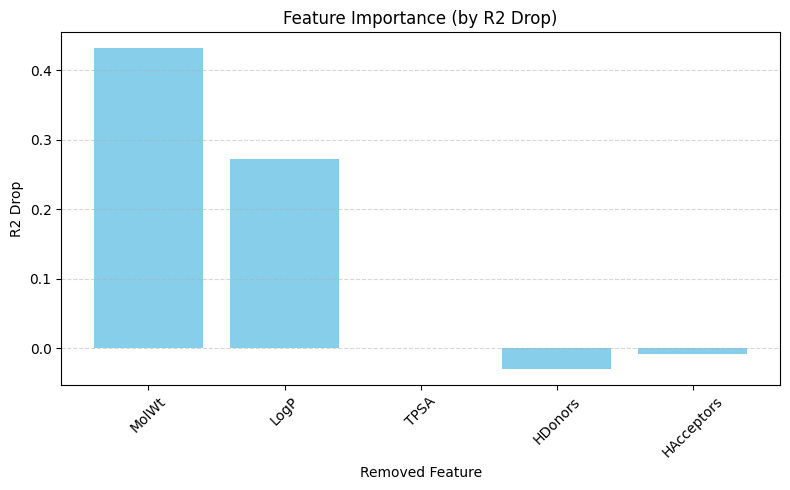

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results_df['Removed'], results_df['R2_drop'], color='skyblue')
plt.ylabel("R2 Drop")
plt.xlabel("Removed Feature")
plt.title("Feature Importance (by R2 Drop)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()